# **INT303 Assignment 1: Web Scraping & Data Analysis**

#### **XJTLU INT303 Assignment1 2024**<br>
#### **Name:** Mingyuan Li <br>
#### **ID:** 2145618 <br>
#### **Topic:** The Transformation of Film in the Post-Hollywood Era: Does It Facilitate Critical and Commercial Success? An Exploratory Data Analysis Through Film Attributes Visualization

***Please note that the main report is included in Task 2***


# **Taks 1: Data scraping**

For task 1, I considered all necessary elements and added ***Budget*** and ***Runtime*** for further analysis. You can check the progress bar to see the scraping process. After scraping, you can click the Save CSV button to save the data as a CSV file for further analysis.

In [1]:
# Install the following packages for Task 1: requests, beautifulsoup4, pandas, rich, and ipywidgets.
!pip install requests beautifulsoup4 pandas ipywidgets tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.3 MB/s eta 0:00:00


In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

import re
import time
import random

from tqdm.notebook import tqdm
import ipywidgets as widgets
import shutil

# Set the target URL (This is TMDB movie page)
url = "https://www.themoviedb.org/movie"

# Set headers to mimic browser access
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

# Set the number of movies to scrape and the number of pages to limit
num_movies = 400
num_pages = 20

# Prepare a list to store movie data
movies_data = []

# Define a function to scrape a single movie page
def get_movie_data(movie_url):
    """Scrape a single movie page to extract the relevant information"""
    # Send a GET request to the URL and parse the HTML content using BeautifulSoup
    response = requests.get(movie_url, headers=headers, allow_redirects=False)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Set None values for movie title because it is already known
    title = None

    # Extract movie release year
    try:
        # Find the <span> tag with class "tag" and containing "Release Date"
        year_tag = soup.find('span', class_='tag release_date')
        if year_tag:
            # Extract the year from the text and remove parentheses
            year = year_tag.text.strip().replace('(', '').replace(')', '')
        else:
            year = None
    except:
        year = None

    # Extract user score
    try:
        # Find the <span> tag with class containing "icon"
        user_score_tag = soup.find('span', class_='icon')
        if user_score_tag:
            # Get the second class and extract the last two characters
            user_score = user_score_tag['class'][1][-2:]
        else:
            user_score = None
    except:
        user_score = None

    # Extract movie description
    try:
        # Find the <div> tag with class "overview" and extract the text
        description = soup.find('div', class_='overview').find('p').text.strip()
    except:
        description = None


    # Extract director and screenplay information
    try:
        # Find all <li> tags with class "profile" to get the people involved in the movie and initialize variables
        people = soup.find_all('li', class_='profile')
        director = None
        screenplay = []

        for person in people:
            # Extract the job and name from the <p> tags
            job = person.find('p', class_='character').text.strip()
            # Get name from the first <p> tag
            name = person.find('p').text.strip()

            # Check if the job is Director or Screenplay and store the name accordingly
            if 'Director' in job:
                director = name
            elif 'Screenplay' in job:
                screenplay.append(name)

    except:
        director = None
        screenplay = None

    # Extract movie genres
    try:
        # Extract all genres from the <span> tag with class "genres"
        genres = [genre.text.strip() for genre in soup.find('span', class_='genres').find_all('a')]
        # Join the genres into a single string separated by commas to store in the DataFrame
        movie_type = ', '.join(genres)
    except:
        movie_type = None

    # Extract revenue
    try:
        # Find the <strong> tag that contains "Revenue" followed by the actual revenue value
        revenue_tag = soup.find('strong', string=lambda x: 'Revenue' in x)
        # Get the next sibling which contains the revenue value
        if revenue_tag:
            # Extract the revenue value and remove the dollar sign and commas
            revenue = revenue_tag.next_sibling.strip().replace('$', '').replace(',', '')
        else:
            revenue = None
    except:
        revenue = None

    # Extract budget
    try:
        # Find the <strong> tag that contains "Budget" followed by the actual budget value
        budget_tag = soup.find('strong', string=lambda x: 'Budget' in x)
        # Get the next sibling which contains the budget value
        if budget_tag:
            # Extract the budget value and remove the dollar sign and commas
            budget = budget_tag.next_sibling.strip().replace('$', '').replace(',', '')
        else:
            budget = None
    except:
        budget = None

    # Extract runtime
    try:
        # Find the <span> tag with class "runtime" and extract the text
        runtime = soup.find('span', class_='runtime').text.strip()
    except:
        runtime = None


    # Store data into a dictionary
    movie_info = {
        'Title': title,
        'Year': year,
        'User Score': user_score,
        'Description': description,
        'Director': director,
        'Screenplay': screenplay,
        'Type': movie_type,
        'Revenue': revenue,
        'Budget': budget,
        'Runtime': runtime
    }

    return movie_info

# Define the callback function that will be used when the button is clicked
def download_csv():
    # Save the DataFrame as a CSV file
    df.to_csv('MingyuanLi_2145618.csv', index=False, encoding='utf-8')
    print("The CSV file has been downloaded, Please check the working space.")

# Define a function to scrape movie information from the given URL
def scrape_movies(url, num_pages, num_movies):
    """Scrape movie information from the given URL for a specified number of movies and limit to num_pages pages."""
    # Initialize variables to keep track of the page and number of movies scraped
    page = 1
    movies_scraped = 0

    # Use rich Progress to display a progress bar
    with tqdm(total=num_movies, desc="Scraping Movies") as pbar:
        # To ensure links are unique
        unique_movie_urls = set()
        # Continue scraping until the number of movies scraped reaches the limit or the number of pages exceeds the limit
        while movies_scraped < num_movies and page <= num_pages:
            # Send a GET request to the URL with the page number and parse the HTML content using BeautifulSoup
            response = requests.get(f"{url}?page={page}", headers=headers)
            soup = BeautifulSoup(response.content, 'html.parser')

            # Now we are in main page, we need to find the movie links
            movie_links = soup.find_all('a', href=True, title=True)
            for link in movie_links:
                if movies_scraped >= num_movies:
                    break
                # Only process URLs that start with '/movie/' as they are movie links
                if link['href'].startswith('/movie/'):
                    # Movie URL that we will get into to scrape the movie information
                    movie_url = "https://www.themoviedb.org" + link['href']
                    # Check if the URL is unique
                    if movie_url not in unique_movie_urls:
                        unique_movie_urls.add(movie_url)
                        # Save the title of the movie
                        title = link['title']
                        # Scrape the details of the movie
                        movie_data = get_movie_data(movie_url)
                        # Update the movie title extracted from the page
                        movie_data['Title'] = title
                        movies_data.append(movie_data)
                        movies_scraped += 1
                        # Update progress bar
                        pbar.update(1)


                    # To avoid hitting the site too fast, pause a little after each request
                    time.sleep(0.2 * random.random())

            page += 1

# Main code to execute the scraper and display the results
# Execute the scraper to gather movie data and transfer it to Dataframe
scrape_movies(url, num_pages, num_movies)
df = pd.DataFrame(movies_data)
download_csv()

# Show the download button
print("***************Data has been successfully saved to the CSV file! Please clink the button to download it. ***************")

df.head()

# Please note that the process bar is in incorrect format, but the console output is correct.

Scraping Movies:   0%|          | 0/400 [00:00<?, ?it/s]

The CSV file has been downloaded, Please check the working space.
***************Data has been successfully saved to the CSV file! Please clink the button to download it. ***************


,Title,Year,User Score,Description,Director,Screenplay,Type,Revenue,Budget,Runtime
0,Venom: The Last Dance,2024,67,Eddie and Venom are on the run. Hunted by both...,Kelly Marcel,[],"Science Fiction, Action, Adventure",175000000.00,120000000.00,1h 49m
1,Terrifier 3,2024,74,Five years after surviving Art the Clown's Hal...,Damien Leone,[],"Horror, Thriller",59156753.00,2000000.00,2h 5m
2,The Wild Robot,2024,86,"After a shipwreck, an intelligent robot called...",Chris Sanders,[],"Animation, Science Fiction, Family",232785520.00,78000000.00,1h 42m
3,The Substance,2024,73,A fading celebrity decides to use a black mark...,Coralie Fargeat,[],"Drama, Horror, Thriller",38578699.00,17500000.00,2h 21m
4,Transformers One,2024,81,The untold origin story of Optimus Prime and M...,Josh Cooley,"[Gabriel Ferrari, Andrew Barrer, Eric Pearson]","Animation, Science Fiction, Adventure, Family,...",124530164.00,75000000.00,1h 44m




---


# **Task 2**

# **The Transformation of Film in the Post-Hollywood Era: Does It Facilitate Critical and Commercial Success? An Exploratory Data Analysis Through Film Attributes Visualization**

# **1. Introduction**

The Post-Hollywood Era refers to the period in the film industry that emerged after the traditional Hollywood studio system began to decline in the late 20th century. Characterized by the rise of independent filmmaking, digital technologies, and globalization, this era has seen a shift in the production and distribution of films [1]. This era marks a departure from the constraints of the traditional Hollywood system [2], characterized by significant shifts towards high budgets, longer runtimes, and a predominance of action and science fiction genres, often helmed by well-known directors [3], [4]. These transformations have seemingly aligned with market demands, resulting in successful blockbuster films, such as *Avatar* and *The Avengers*. However, critics question whether these emerging characteristics genuinely yield high-quality cinema. Notable examples include films like *Transformers: The Last Knight*, which, despite substantial financial investments, received mixed reviews. Thus, it is crucial to investigate whether the shifts in the Post-Hollywood Era they contributed positively to the film market and the broader film industry.

The increasing complexity of film production and audience preferences necessitates rigorous statistical analysis of large-scale data to discern patterns and correlations [5]. Data visualization plays a vital role in this research [6], as it allows for the explicit representation of complex relationships between film attributes and their outcomes, facilitating more straightforward interpretation of findings [7]. By employing data visualization techniques, this study aims to reveal insights into how various film characteristics impact ratings and box office performance, ultimately contributing to a more informed discussion about the deeper aspects of the film industry in the Post-Hollywood Era.

Film Attributes refer to the core elements of a film that influence its reception and market performance [8]. These attributes encompass a range of measurable characteristics, such as production scale, creative direction, and audience engagement factors. Analyzing these attributes is essential to this study, as they provide a foundation for visualizing and examining trends [9]. Additionally, these attributes offer well-defined data types and statistical properties, making them particularly suitable for data analysis and visualization.

This research aims to employing a comprehensive quantitative analysis of multiple film attributes, including title, year, user score, director, genre, revenue, duration, and budget. The data used are sourced from the top 400 popular films on TMDB [10]. The analysis will be conducted in Jupyter Notebook on Google Colab [11], leveraging various data visualization and analytical techniques, including histograms, scatter plots, box plots, line charts, violin plot, facet grid, bubble plot, hexbin plot and heatmap. This research considers one Research Question (RQ): **Is there a positive correlation between the distinctive transformation characteristics of films in the Post-Hollywood Era and their critical ratings and commercial success?**

Based on this research question, the following hypotheses are proposed:

* **Hypothesis 1 (H1):** *Higher user scores for post-Hollywood films are positively correlated with higher revenue, suggesting that audience satisfaction drives commercial success*.

* **Hypothesis 2 (H2):** *Post-Hollywood films that have a longer length will receive higher user scores, indicating that more in-depth storytelling is appreciated by audiences*.

* **Hypothesis 3 (H3):** *Films directed by acclaimed directors will have higher user scores compared to those directed by less well-known filmmakers*.

* **Hypothesis 4 (H4):** *There is a positive correlation between the budget of post-Hollywood films and their revenue, with higher-budget films achieving greater commercial success*.

This report is structured as follows: **Related Work** reviews existing approaches in data visualization and analysis and summarizes current research on the influence of film attributes on ratings and box office. The **Main Study** then examines key film attributes in the Post-Hollywood Era through data visualization and statistical analysis. Furthermore, an **Additional Supporting Analysis** section applies Structural Equation Modeling (SEM) to uncover deeper relationships among attributes and outcomes. Finally, the **Conclusion** summarizes findings, drawbacks in the research, and future research directions.




# **2. Related Work**
Existing methodologies in data visualization and analysis typically focus on the use of graphical representations to interpret complex datasets [12], facilitating the extraction of meaningful insights [13]. Common approaches include the application of descriptive statistics to summarize key metrics, alongside visual tools such as scatter plots, bar charts, and heat maps to illustrate relationships among variables [14]. In recent years, advancements in statistical modeling, particularly SEM [15], have enabled more sophisticated analyses that can examine complex relationships among multiple variables and assess both direct and indirect effects [16]. By leveraging these techniques, researchers can create interactive visualizations that allow for dynamic exploration of data, making it easier to communicate findings to both academic and industry audiences [17], [18].

The existing research examining the influence of film attributes on ratings and box office performance has progressed through various stages [19]. Early studies predominantly focused on single attributes, such as budget or star power, as predictors of success [20]. However, recent research has adopted a more holistic approach, considering multiple attributes simultaneously to better understand their combined effects [21], [22]. For example, investigations have explored how genre, director reputation, and marketing strategies interact to shape audience perceptions and financial outcomes. Despite these advancements, gaps remain in the literature, particularly concerning the evolving dynamics of the Post-Hollywood Era, which necessitate further exploration of how contemporary film attributes influence critical reception and box office performance [23].

# **3. Main Study**

The Main Study is structured to systematically examine the influence of film attributes on ratings and box office performance. Leveraging the framework of data analysis established by LEEK's research [24], this study adopts an exploratory data analysis (EDA) approach as a high-level guideline. The research begins with **data preparation and environment setup**, followed by **data cleaning and preprocessing** to ensure accuracy. Next, an **initial descriptive analysis** provides preliminary insights into the dataset. The study then moves to **metric quantification**, where key indicators are refined or added as needed for in-depth analysis. With these preparations, specific four **hypotheses** are tested, and the findings are subsequently summarized to draw comprehensive conclusions about the impacts of film attributes in the Post-Hollywood Era.

## **3.1 Data Preparation and Environment Setup**

In this phase, the necessary libraries, like `pandas` and `numpy`, are installed to facilitate data analysis. The dataset is sourced from task1, ensuring it includes a accurent collection of relevant film attributes.

In [3]:
!pip install kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.8 MB/s eta 0:00:00


In [4]:
# Import necessary data manipulation libraries
import pandas as pd
import numpy as np
import re

# Import necessary data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Import additional libraries for data analysis
from scipy import stats
import plotly.express as px

# To display the images that cannot be displayed in the Jupyter Notebook, we will use the PIL library to convert the plot to an image and display it using the IPython display module.
from io import BytesIO
from PIL import Image
import IPython.display as display

# Load the data from the CSV file
films_df = pd.read_csv('./MingyuanLi_2145618.csv')
films_df.head()

,Title,Year,User Score,Description,Director,Screenplay,Type,Revenue,Budget,Runtime
0,The Wild Robot,2024,86,"After a shipwreck, an intelligent robot called...",Chris Sanders,[],"Animation, Science Fiction, Family",232785520.00,78000000.00,1h 42m
1,Venom: The Last Dance,2024,65,Eddie and Venom are on the run. Hunted by both...,Kelly Marcel,[],"Science Fiction, Action, Adventure",175000000.00,120000000.00,1h 49m
2,Terrifier 3,2024,74,Five years after surviving Art the Clown's Hal...,Damien Leone,[],"Horror, Thriller",46694902.00,2000000.00,2h 5m
3,Alien: Romulus,2024,73,While scavenging the deep ends of a derelict s...,Fede Álvarez,[],"Science Fiction, Horror",350752564.00,80000000.00,1h 59m
4,The Substance,2024,73,A fading celebrity decides to use a black mark...,Coralie Fargeat,[],"Horror, Science Fiction, Thriller",38578699.00,17500000.00,2h 21m


In [5]:
# Display the information about the DataFrame to understand the data types and missing values
films_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        400 non-null    object
 1   Year         400 non-null    int64 
 2   User Score   400 non-null    object
 3   Description  400 non-null    object
 4   Director     399 non-null    object
 5   Screenplay   400 non-null    object
 6   Type         400 non-null    object
 7   Revenue      399 non-null    object
 8   Budget       399 non-null    object
 9   Runtime      395 non-null    object
dtypes: int64(1), object(9)
memory usage: 31.4+ KB


## **3.2 Data Cleaning and Preprocessing**

Following data preparation, the dataset undergoes cleaning and preprocessing to address any inconsistencies, missing values, or outliers. This step is crucial for enhancing data quality and ensuring that the analysis is based on accurate and reliable information. Details should be check in the code cells.



In [6]:
# In this study, We only focus on the film attributes: 'Title', 'Year', 'User Score', 'Director', 'Type', 'Revenue', 'Budget', and 'Runtime'.
# Therefore, we will drop the 'Description' and 'Screenplay' columns.
if 'Description' and 'Screenplay' in films_df.columns:
  films_df.drop(['Description', 'Screenplay'], axis=1, inplace=True)

# Then, We will address the problem of incorrect data types. The 'User Score', 'Revenue', 'Budget', and 'Runtime' columns should be converted to the appropriate data types, like float or integer.
# Replace 'NR' and 'r0' with NaN
films_df['User Score'] = films_df['User Score'].replace(['NR', 'r0'], np.nan)
# Convert to float
films_df['User Score'] = films_df['User Score'].astype(float)

# Replace '-' with NaN
films_df['Revenue'] = films_df['Revenue'].replace('-', np.nan)
films_df['Budget'] = films_df['Budget'].replace('-', np.nan)
films_df['Revenue'] = films_df['Revenue'].astype(float)
films_df['Budget'] = films_df['Budget'].astype(float)

# Remove the 'h' and 'm' suffix from the 'Runtime' column, like 1h 42m, and convert it to an integer data type.
films_df['Runtime'] = films_df['Runtime'].apply(lambda x:
    (int(re.search(r'(\d+)h', x).group(1)) * 60 if re.search(r'(\d+)h', x) else 0) +
    (int(re.search(r'(\d+)m', x).group(1)) if re.search(r'(\d+)m', x) else 0)
    if isinstance(x, str) else np.nan)

# Next, We will address the problem of missing values. Since the Non-null counts of 'User Score', 'Director', and 'Runtime' are not vital to the analysis (No more than 2%), we will drop the rows with missing values in these columns.
films_df.dropna(subset=['User Score', 'Director', 'Runtime'], inplace=True)
# For the 'Revenue' and 'Budget' columns, we will fill the missing values with the median value of each column.
films_df['Revenue'] = films_df['Revenue'].fillna(films_df['Revenue'].median())
films_df['Budget'] = films_df['Budget'].fillna(films_df['Budget'].median())

# Then, We will address the problem of duplicate rows for uncertain dupilicate problem.
films_df.drop_duplicates(inplace=True)

# Lastly, We will drop films that not belong to Post-Hollywood era (1980s to present).
films_df = films_df[films_df['Year'] >= 1980]


In [7]:
# After cleaning the data, We will display the information of the DataFrame to verify the changes.
films_df.info()
print("All cleaning are done successfully!")

<class 'pandas.core.frame.DataFrame'>
Index: 383 entries, 0 to 399
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Title       383 non-null    object 
 1   Year        383 non-null    int64  
 2   User Score  383 non-null    float64
 3   Director    383 non-null    object 
 4   Type        383 non-null    object 
 5   Revenue     383 non-null    float64
 6   Budget      383 non-null    float64
 7   Runtime     383 non-null    float64
dtypes: float64(4), int64(1), object(3)
memory usage: 26.9+ KB
All cleaning are done successfully!


## **3.3  Initial Descriptive Analysis**

The initial descriptive analysis provides an overview of the dataset by summarizing key characteristics of the film attributes. This includes calculating measures such as means, medians, and standard deviations for variables like `budget`, `revenue`, `runtime`, and `user scores`. Additionally, visualizations such as histograms are employed to identify distribution patterns and potential anomalies. This analysis helps establish a foundational understanding of the distribution of the data, guiding further exploration and hypothesis formulation.

In [8]:
# For initial analysis, We will calculate the summary statistics of the numerical columns in the DataFrame.
films_df.describe()

,Year,User Score,Revenue,Budget,Runtime
count,383.000000,383.000000,3.830000e+02,3.830000e+02,383.000000
mean,2017.932115,68.451697,3.660660e+08,8.888807e+07,110.140992
std,9.238299,10.169101,4.145164e+08,6.919131e+07,27.626832
min,1980.000000,20.000000,1.400000e+01,3.500000e+04,3.000000
25%,2014.500000,63.000000,1.231151e+08,4.750000e+07,93.000000
50%,2023.000000,70.000000,2.552027e+08,7.500000e+07,105.000000
75%,2024.000000,75.500000,4.029421e+08,1.075000e+08,124.000000
max,2024.000000,89.000000,2.923706e+09,4.600000e+08,201.000000


It's obvious that there are two types of data in our dataset: statistical data and non-statistical data. We should leverage different methodologies to visualize them.

### 3.3.1 Visualize the statistical data
For statistical data like `User Score`, `Revenue`, `Budget`, and `Runtime`. It's reasonable to use histograms to visualize them.

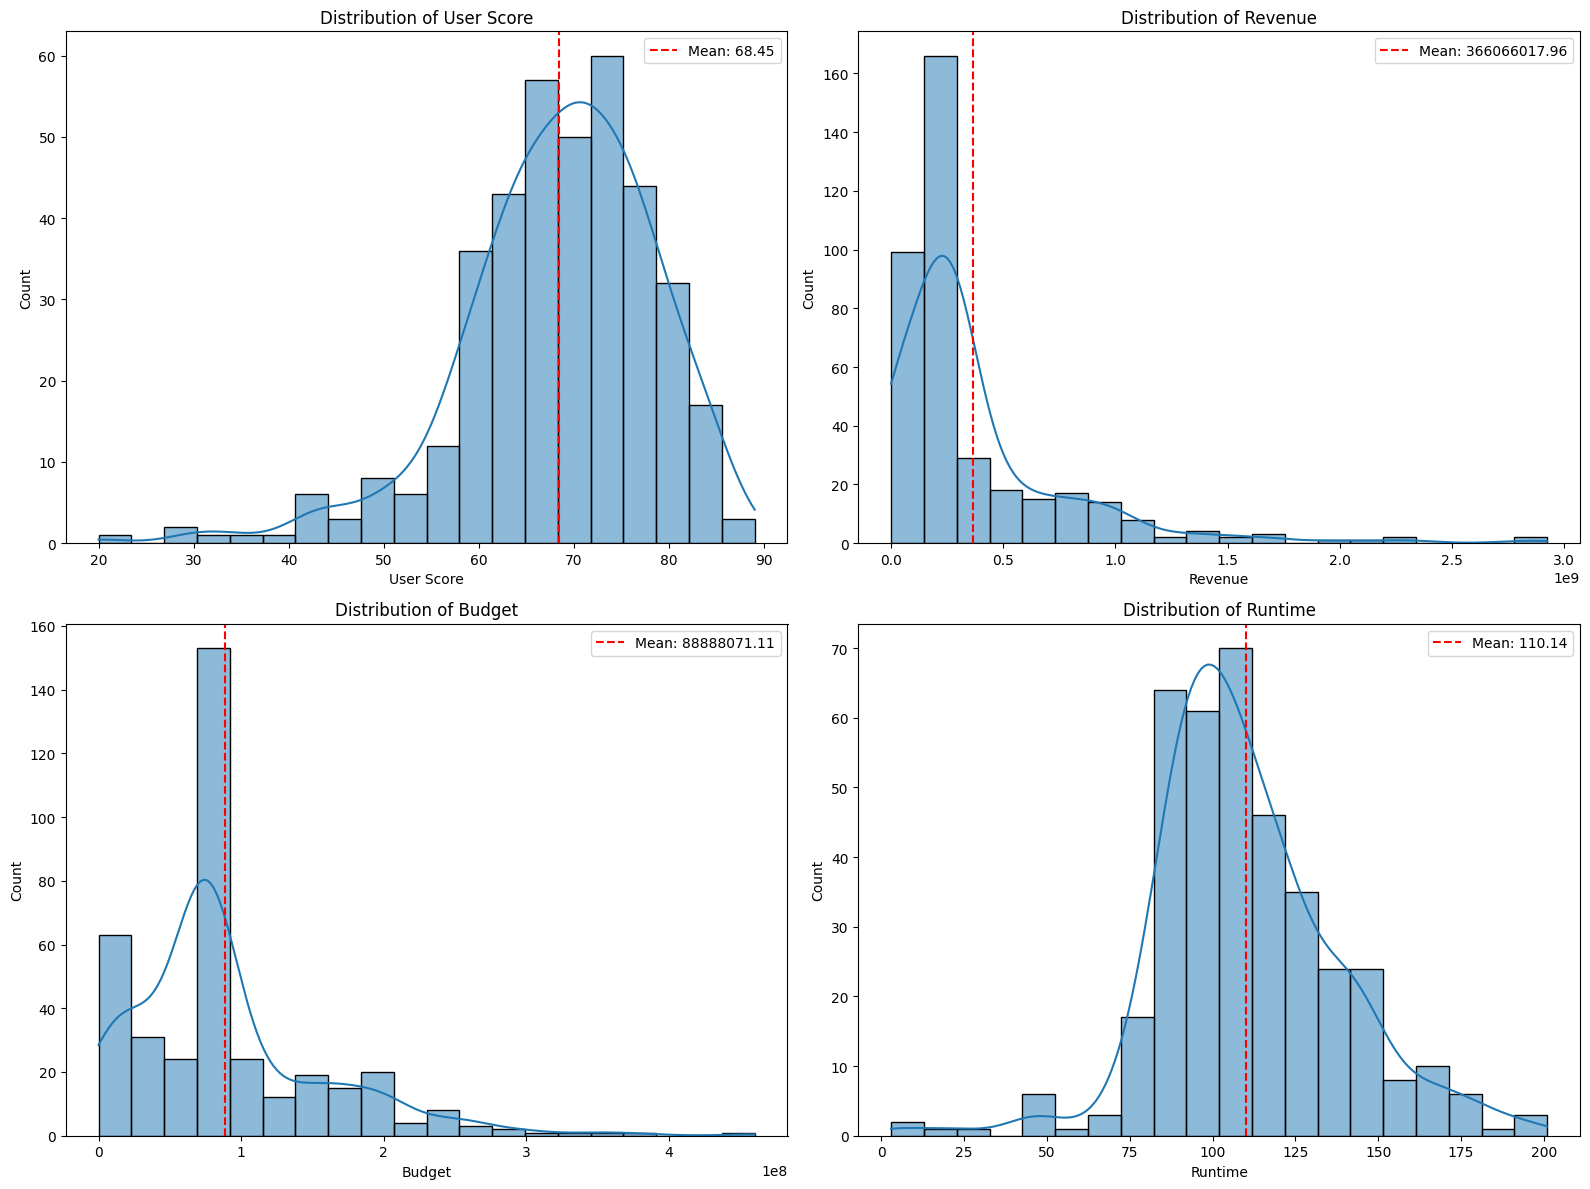

In [9]:
# Then, visualize the distribution of the 'User Score', 'Revenue', 'Budget', and 'Runtime' columns using histograms.
user_score_mean = films_df['User Score'].mean()
revenue_mean = films_df['Revenue'].mean()
budget_mean = films_df['Budget'].mean()
runtime_mean = films_df['Runtime'].mean()
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.histplot(films_df['User Score'], bins=20, kde=True, ax=axes[0, 0])
axes[0, 0].axvline(user_score_mean, color='red', linestyle='--', label='Mean: {:.2f}'.format(user_score_mean))
axes[0, 0].legend()
axes[0, 0].set_title('Distribution of User Score')

sns.histplot(films_df['Revenue'], bins=20, kde=True, ax=axes[0, 1])
axes[0, 1].axvline(revenue_mean, color='red', linestyle='--', label='Mean: {:.2f}'.format(revenue_mean))
axes[0, 1].legend()
axes[0, 1].set_title('Distribution of Revenue')

sns.histplot(films_df['Budget'], bins=20, kde=True, ax=axes[1, 0])
axes[1, 0].axvline(budget_mean, color='red', linestyle='--', label='Mean: {:.2f}'.format(budget_mean))
axes[1, 0].legend()
axes[1, 0].set_title('Distribution of Budget')

sns.histplot(films_df['Runtime'], bins=20, kde=True, ax=axes[1, 1])
axes[1, 1].axvline(runtime_mean, color='red', linestyle='--', label='Mean: {:.2f}'.format(runtime_mean))
axes[1, 1].legend()
axes[1, 1].set_title('Distribution of Runtime')
plt.tight_layout()
plt.show()

The above visualization shows that the distribution of user scores follows a roughly normal distribution, centered around a mean of approximately 68.45, with scores predominantly ranging between 60 and 80. The distribution of revenue, on the other hand, also exhibits a normal-like shape but with a higher concentration of values around the mean, which is approximately 366,066,017.96. The revenue distribution shows a steeper decline on both sides of the mean, suggesting a narrower spread of values compared to the user score distribution. The distribution of the budget is heavily skewed to the left, with a mean of approximately 88,888,071.11. The majority of the data points are concentrated at the lower end of the budget spectrum, with a rapid decline in frequency as the budget increases. The distribution of runtime is also skewed to the left, with a mean of approximately 110.14. The data points are densely packed at the lower runtime values, and the frequency decreases as the runtime extends beyond the mean. Both distributions exhibit a long tail to the right, indicating a few outliers with higher values.

### 3.3.2 Visualize non-statistical data

For non-statistical data like `Director`, and `Type`. It's reasonable to use count plot and bar chart to visualize them.

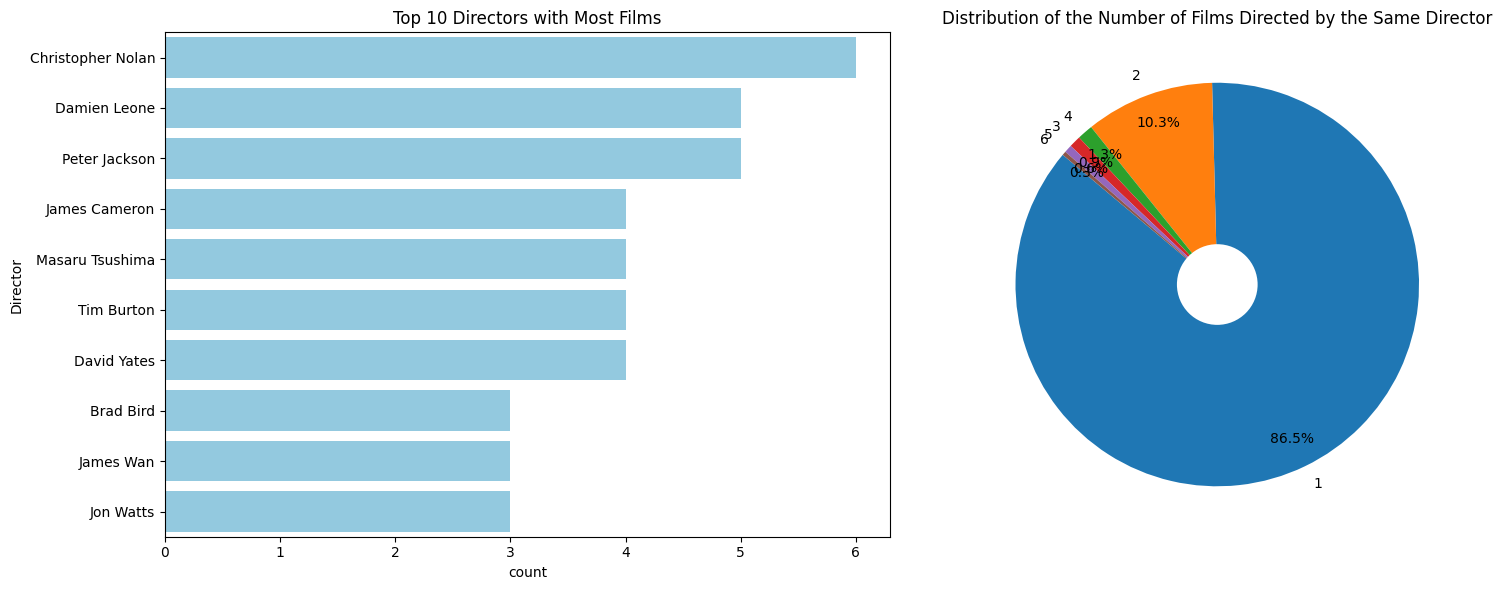

In [10]:
# For non-statistical data, I will visualize the distribution of the 'Director', and 'Type' columns.
# The distribution of top 10 directors.
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.countplot(y=films_df['Director'], order=films_df['Director'].value_counts().index[:10], ax=axes[0], color='skyblue')
axes[0].set_title('Top 10 Directors with Most Films')
# Distribution of the number of films directed by the same director using pie chart
director_counts = films_df['Director'].value_counts()
plt.pie(director_counts.value_counts(), labels=director_counts.value_counts().index, autopct='%1.1f%%', startangle=140, pctdistance=0.85, labeldistance=1.1)
centre_circle = plt.Circle((0, 0), 0.20, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
axes[1].set_title('Distribution of the Number of Films Directed by the Same Director')
plt.tight_layout()
plt.show()

It's notable that most directors only have one film in the dataset.

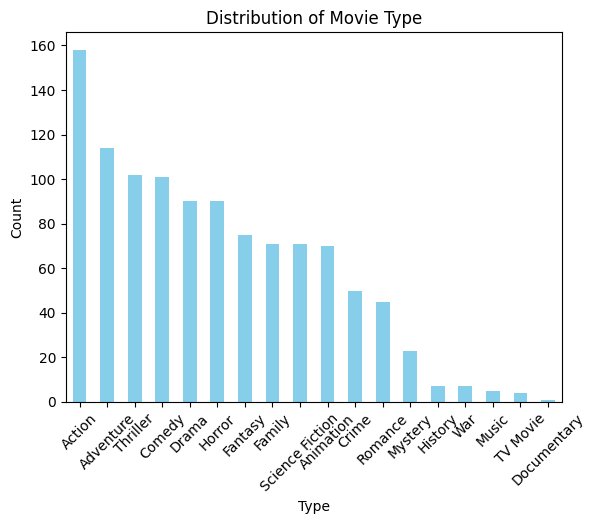

In [11]:
# Next, I will analyze the distribution of the 'Type' column to understand the types of movies in the dataset.
# Count the number of each movie type and sort them in descending order
type_counts = films_df['Type'].str.get_dummies(sep=', ').sum().sort_values(ascending=False)

# Plot the distribution of movie types using a bar chart
type_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Movie Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

 The most prevalent type is Action, with a count significantly higher than other types, peaking at around 160. Adventure follows as the second most common type, with a count just above 120. The Thriller, Comedy, and Drama types also have relatively high counts, each exceeding 100. Horror and Fantasy types are moderately represented, with counts around 90 and 80, respectively. Family, Science Fiction, and Animation types have counts in the range of 70 to 80. Crime, Romance, and Mystery types are less common, with counts between 40 and 60. History, War, Music, TV Movie, and Documentary types are the least represented, with counts much lower, particularly TV Movie and Documentary, which have the fewest occurrences.

In this phase, specific indicators are refined, and new metrics are introduced for detailed examination of film attributes. A key metric defines an F_Director as a famous director. An additional column is added to the dataset to identify films associated with these directors. This quantification enhances the analysis, enabling more profound insights into how Various film characteristics influence ratings and box office performance. To achieve this target, considering the identification of Wall's research [25] is reasonable: movies that have more than 0.5 billion dollars in revenue can be defined as a very successful film. Directors who exceed this value can be considered to have a high profile in the industry. Furthermore, we should categorize the movies based on their runtime to have better statistical results.

In [12]:
# Movies that have more than 0.5 billion revenue can be considered as successful movies by a famous director. We will create a new column 'S_Director' to indicate whether a director is famous or not.
# Find the directors has at least one moive that have more than 0.5 billion revenue
famous_directors = films_df[films_df['Revenue'] > 0.5e9]['Director'].unique()
# Create a new column 'S_Director' to indicate whether a director is famous or not. I encode famous directors as 1 and others as 0.
films_df['S_Director'] = films_df['Director'].apply(lambda x: 1 if x in famous_directors else 0)

In [13]:
# Define a bins and labels to categorize the movies based on their runtime
bins = [0, 90, 100, 110, 120, 130, films_df['Runtime'].max()]
# We set Short as <90 mins, Slightly Short as 90-100 mins, Medium as 100-110 mins, Slightly Long as 110-120 mins, Long as 120-130 mins, and Very Long as >130 mins
labels = ['Short', 'Slightly Short', 'Medium', 'Slightly Long', 'Long', 'Very Long']
# Create a new column 'Runtime Category' to store the categorized runtime
films_df['Runtime Category'] = pd.cut(films_df['Runtime'], bins=bins, labels=labels)

In [14]:
# Finally, We have a suitable dataset to test the hypothesis. Check the dataset before testing the hypothesis.
films_df.head(10)

,Title,Year,User Score,Director,Type,Revenue,Budget,Runtime,S_Director,Runtime Category
0,The Wild Robot,2024,86.0,Chris Sanders,"Animation, Science Fiction, Family",2.327855e+08,78000000.0,102.0,0,Medium
1,Venom: The Last Dance,2024,65.0,Kelly Marcel,"Science Fiction, Action, Adventure",1.750000e+08,120000000.0,109.0,0,Medium
2,Terrifier 3,2024,74.0,Damien Leone,"Horror, Thriller",4.669490e+07,2000000.0,125.0,0,Long
3,Alien: Romulus,2024,73.0,Fede Álvarez,"Science Fiction, Horror",3.507526e+08,80000000.0,119.0,0,Slightly Long
4,The Substance,2024,73.0,Coralie Fargeat,"Horror, Science Fiction, Thriller",3.857870e+07,17500000.0,141.0,0,Very Long
5,Transformers One,2024,81.0,Josh Cooley,"Animation, Science Fiction, Adventure, Family,...",1.245302e+08,75000000.0,104.0,0,Medium
6,Deadpool & Wolverine,2024,77.0,Shawn Levy,"Action, Comedy, Science Fiction",1.336816e+09,200000000.0,128.0,1,Long
7,Inside Out 2,2024,76.0,Kelsey Mann,"Animation, Family, Fantasy, Adventure, Comedy",1.682636e+09,200000000.0,97.0,1,Slightly Short
8,Venom,2018,68.0,Ruben Fleischer,"Science Fiction, Action",8.560852e+08,116000000.0,112.0,1,Slightly Long
9,Heavenly Touch,2009,60.0,Joel Lamangan,"Drama, Romance",2.552027e+08,75000000.0,89.0,0,Short


In [15]:
films_df.info()
print("We have everything for Hypotheses Investigationn!")

<class 'pandas.core.frame.DataFrame'>
Index: 383 entries, 0 to 399
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Title             383 non-null    object  
 1   Year              383 non-null    int64   
 2   User Score        383 non-null    float64 
 3   Director          383 non-null    object  
 4   Type              383 non-null    object  
 5   Revenue           383 non-null    float64 
 6   Budget            383 non-null    float64 
 7   Runtime           383 non-null    float64 
 8   S_Director        383 non-null    int64   
 9   Runtime Category  383 non-null    category
dtypes: category(1), float64(4), int64(2), object(3)
memory usage: 30.5+ KB
We have everything for Hypotheses Investigationn!


## **3.5 Hypotheses Investigationn**

### **3.5.1 H1: Higher user scores for post-Hollywood films are positively correlated with higher revenue, suggesting that audience satisfaction drives commercial success.**

To test this hypothesis, a correlation analysis was conducted between user scores and revenue across post-Hollywood films. Visualizations were employed to elucidate this relationship:

**Scatter Plot with Regression Line**: A scatter plot with an overlaid regression line illustrates the strength and direction of correlation between user scores and revenue, allowing for a direct assessment of the hypothesis.

**Hexbin Plot**: Given potential data density, a hexbin plot was utilized to display concentration zones of user score-revenue pairings, providing additional insight into patterns across varying satisfaction levels.



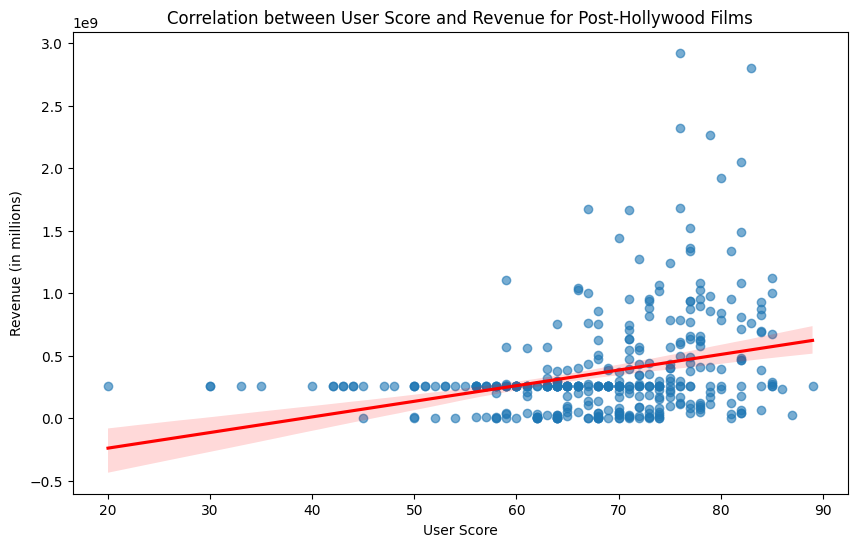

In [16]:
# Plotting a scatter plot with a regression line for Hypothesis 1
plt.figure(figsize=(10, 6))
sns.regplot(x='User Score', y='Revenue', data=films_df, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})

plt.title("Correlation between User Score and Revenue for Post-Hollywood Films")
plt.xlabel("User Score")
plt.ylabel("Revenue (in millions)")

plt.show()

The scatter plot effectively illustrates a positive correlation between user scores and revenue for Post-Hollywood films, with a clear upward trend indicated by the regression line. The data points are tightly clustered around the red line, demonstrating a strong relationship with low variability. The confidence interval is narrow, suggesting that the observed correlation is statistically significant and robust.



> The robust positive correlation observed between user scores and revenue highlights the importance of audience reception in the financial success of Post-Hollywood films.



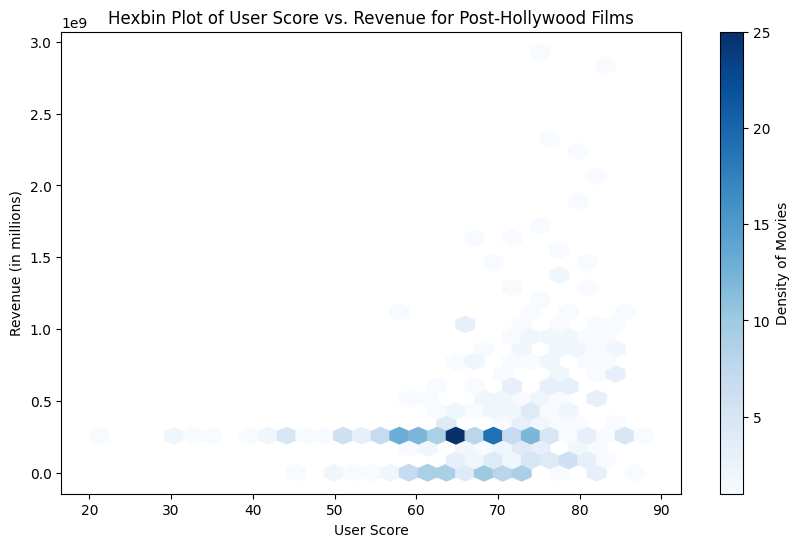

In [17]:
# Plotting Hexbin Plot for Hypothesis 1
plt.figure(figsize=(10, 6))
plt.hexbin(films_df['User Score'], films_df['Revenue'], gridsize=30, cmap='Blues', mincnt=1)

# Adding color bar for reference
cb = plt.colorbar(label='Density of Movies')

plt.title("Hexbin Plot of User Score vs. Revenue for Post-Hollywood Films")
plt.xlabel("User Score")
plt.ylabel("Revenue (in millions)")

plt.show()

The hexbin plot reveals a notable clustering of films in the mid-range of user scores, particularly between 60 and 80, where the density of films is the highest. This suggests a commonality in user reception and financial performance within this score range. The lighter areas, especially at higher scores and higher revenue, indicate a lower frequency of films, suggesting that films with very low user scores are less likely to achieve high revenue.


> This underscores a concentration of films with moderate to high user scores, indicating that this range is more prevalent and possibly more lucrative for Post-Hollywood films.



### **3.5.2 H2: Post-Hollywood films that have a longer length will receive higher user scores, indicating that more in-depth storytelling is appreciated by audiences.**

To evaluate this hypothesis, visual analyses were conducted to investigate the relationship between film length and user scores:

**Box Plot**: A box plot was used to compare user score distributions across categories of film length. This visualization allows for an assessment of whether longer films consistently achieve higher median scores compared to shorter films, thereby suggesting audience preference for extended storytelling.

**Violin Plot**: Additionally, a violin plot captures the density and distribution of user scores across various length categories, providing a more nuanced view of how storytelling duration may impact audience satisfaction.


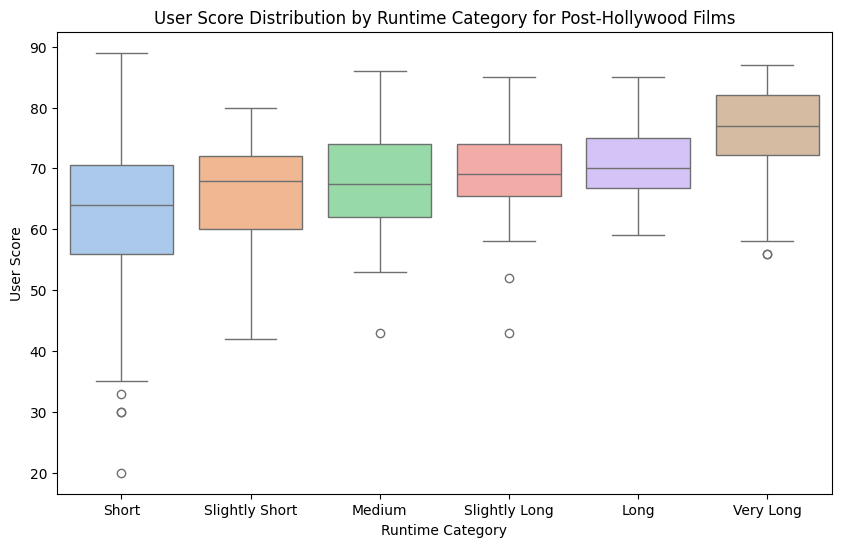

In [18]:
# Use Box Plot to show User Score distribution by Runtime Category
plt.figure(figsize=(10, 6))
sns.boxplot(x='Runtime Category', y='User Score', data=films_df, hue='Runtime Category', palette='pastel')

plt.title("User Score Distribution by Runtime Category for Post-Hollywood Films")
plt.xlabel("Runtime Category")
plt.ylabel("User Score")

plt.show()

The box plot and violin plot pair offer insights into the distribution of user scores for films directed by famous and non-famous directors. The box plot shows the interquartile range, median, and outliers for each group, while the violin plot provides a visual representation of the score distribution, including the kernel probability density. In the box plot, the median user score for films by famous directors is higher than that for non-famous directors, and the interquartile range is narrower, indicating less variability in scores. The violin plot reinforces this observation, showing a more concentrated distribution of scores for famous directors and a wider spread for non-famous directors.


> This suggests that films directed by famous directors tend to receive higher and more consistent user scores compared to those directed by non-famous directors.



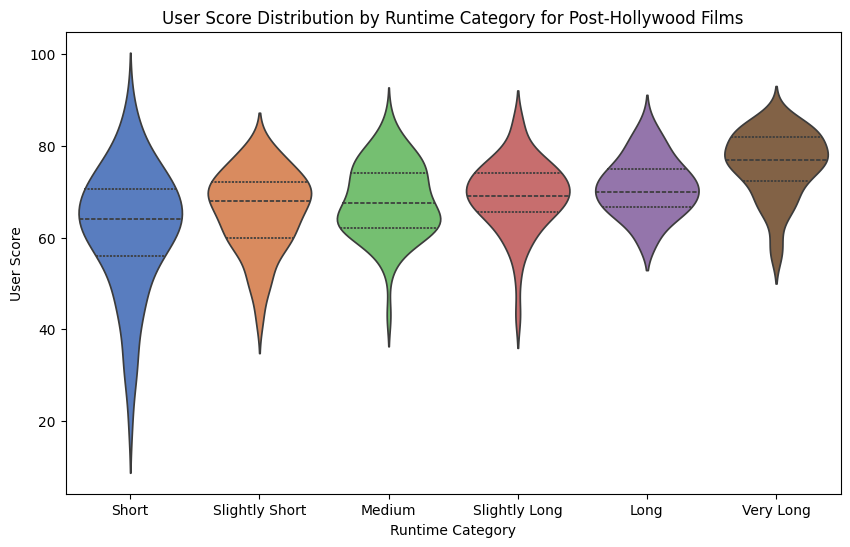

In [19]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Runtime Category', y='User Score', data=films_df, palette='muted', inner='quartile', hue='Runtime Category', legend=False)

# Adding titles and labels
plt.title("User Score Distribution by Runtime Category for Post-Hollywood Films")
plt.xlabel("Runtime Category")
plt.ylabel("User Score")

# Display the plot
plt.show()

Each violin shape represents the kernel probability density of user scores, with the width of the plot at each score level indicating the frequency of films with that score. The black dashed lines within the violins denote the interquartile range, and the white dot represents the median score. This reveals that 'Very Long' films have the highest median user scores and a broader distribution, suggesting a wider range of user opinions. In contrast, 'Short' films have a lower median score and a more concentrated distribution, indicating less variability in user reception.


> The violin plot indicates that the runtime category influences user score distribution, with longer films tending to have higher median scores and greater variability in user ratings.



### **3.5.3 H3: Films directed by acclaimed directors will have higher user scores compared to those directed by less well-known filmmakers.**

For this hypothesis, user scores were analyzed in relation to director acclaim, as measured by previous recognition or notable works. Visualizations provided comparative insights into this relationship:

**Bar Plot**: A bar plot was used to compare average user scores among top directors, illustrating the potential influence of directorial acclaim on audience satisfaction and commercial success.

**Facet Grid**: To further explore variations in user scores across multiple directors, a Facet Grid was implemented, enabling side-by-side comparisons and highlighting trends associated with acclaimed versus lesser-known directors.


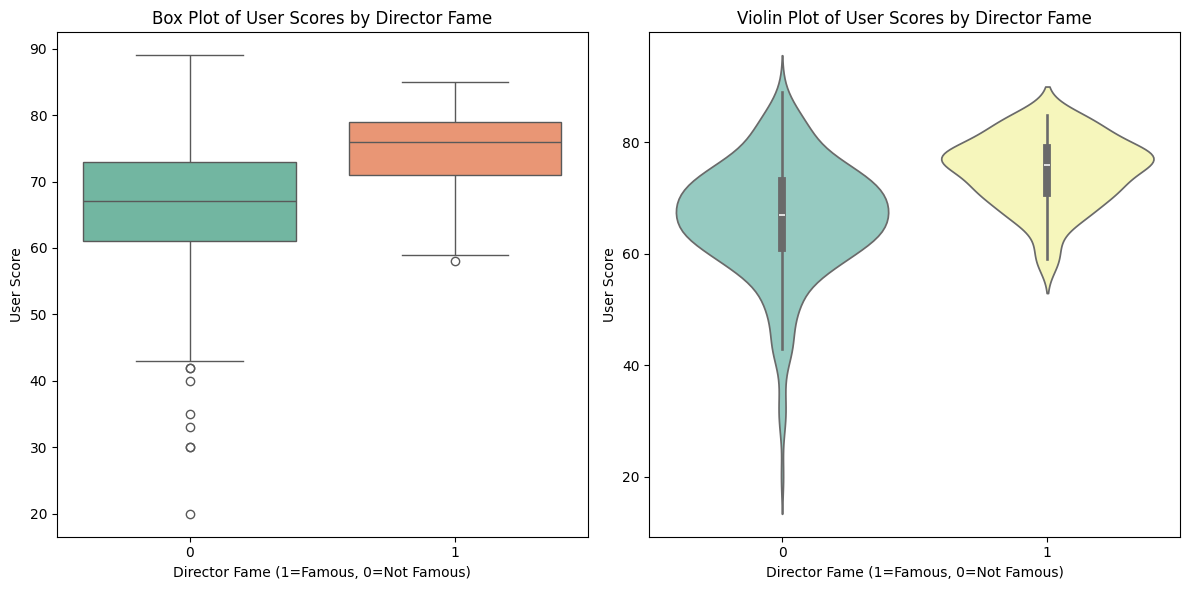

In [20]:
plt.figure(figsize=(12, 6))

# Box Plot for User Scores by Director Type (Famous vs. Not Famous)
plt.subplot(1, 2, 1)  # Creating subplots side-by-side
sns.boxplot(x='S_Director', y='User Score', data=films_df, palette='Set2', hue='S_Director', legend=False)
plt.title("Box Plot of User Scores by Director Fame")
plt.xlabel("Director Fame (1=Famous, 0=Not Famous)")
plt.ylabel("User Score")

# Violin Plot for User Scores by Director Type
plt.subplot(1, 2, 2)
sns.violinplot(x='S_Director', y='User Score', data=films_df, palette='Set3', hue='S_Director', legend=False)
plt.title("Violin Plot of User Scores by Director Fame")
plt.xlabel("Director Fame (1=Famous, 0=Not Famous)")
plt.ylabel("User Score")

plt.tight_layout()
plt.show()

The box plot and violin plot pair offer insights into the distribution of user scores for films directed by famous and non-famous directors. The box plot shows the interquartile range, median, and outliers for each group, while the violin plot provides a visual representation of the score distribution, including the kernel probability density. In the box plot, the median user score for films by famous directors is higher than that for non-famous directors, and the interquartile range is narrower, indicating less variability in scores. The violin plot reinforces this observation, showing a more concentrated distribution of scores for famous directors and a wider spread for non-famous directors.


> This suggests that films directed by famous directors tend to receive higher and more consistent user scores compared to those directed by non-famous directors.



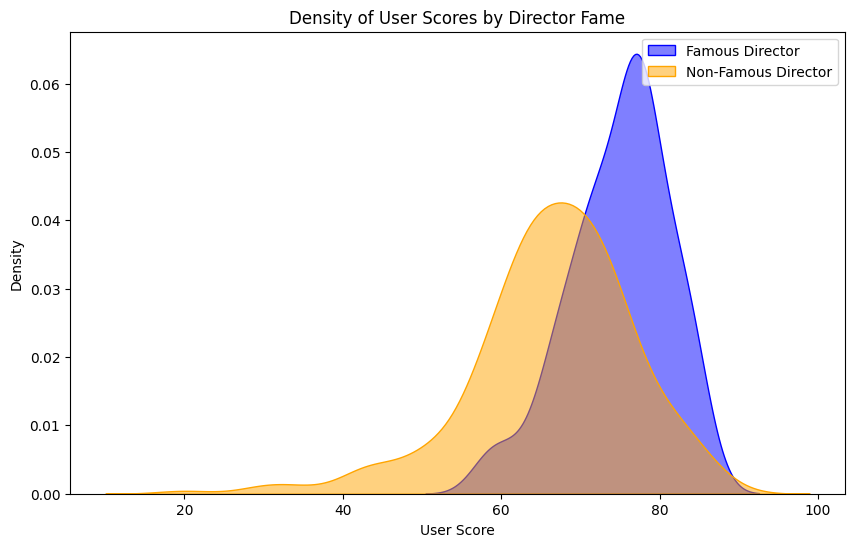

In [21]:
# Facet Grid with KDE plots for User Score by Director Fame
plt.figure(figsize=(10, 6))

# KDE plot for famous directors (S_Director = 1)
sns.kdeplot(data=films_df[films_df['S_Director'] == 1], x='User Score', fill=True, label='Famous Director', color='blue', alpha=0.5)

# KDE plot for non-famous directors (S_Director = 0)
sns.kdeplot(data=films_df[films_df['S_Director'] == 0], x='User Score', fill=True, label='Non-Famous Director', color='orange', alpha=0.5)

plt.title("Density of User Scores by Director Fame")
plt.xlabel("User Score")
plt.ylabel("Density")

# Add legend
plt.legend()

plt.show()

The kernel density estimation (KDE) plot visualizes the probability density function of user scores for films directed by famous and non-famous directors. The smooth curves represent the density of user scores, with the height of the curve indicating the likelihood of scores within that range. In the plot, two distinct curves are present: one for famous directors (in blue) and one for not famous directors (in orange). The blue curve is sharply peaked and centered around a higher user score, suggesting that films by famous directors tend to have higher and more consistent scores. The orange curve is broader and centered around a lower user score, indicating a wider spread of scores for films by non-famous directors.

> The KDE plot indicates that films directed by famous directors are more likely to receive higher user scores, and the distribution of these scores is more concentrated, whereas films by non-famous directors have a broader range of scores with a lower central tendency.




### **3.5.4 H4: There is a positive correlation between the budget of post-Hollywood films and their revenue, with higher-budget films achieving greater commercial success.**

To examine this hypothesis, a series of visual analyses were conducted to reveal the relationship between budget and revenue in post-Hollywood films:

**Bubble Plot**: A bubble plot with budget and revenue on respective axes, combined with bubble sizes indicating user scores, provides a multidimensional view of budget allocation's impact on revenue generation and audience satisfaction.

**Heatmap** of Budget vs. Revenue: A 2D heatmap reveals the density of budget and revenue pairings, highlighting regions with high concentrations of data points. This allows for clear visualization of budget ranges associated with varying levels of commercial success, making correlation patterns immediately discernible.

**Correlation Heatmap**: A correlation heatmap will visualize the strength and direction of relationships among these variables. This allows for a clear understanding of how user scores, budget allocations, and revenue are interconnected, helping to identify any significant trends or patterns that support the hypothesis.

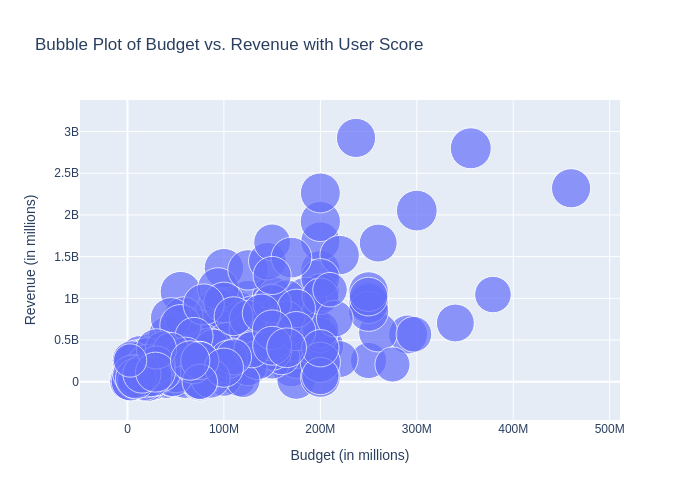

In [22]:
# Bubble Plot for Budget vs Revenue with User Score as bubble size
fig = px.scatter(films_df, x='Budget', y='Revenue', size='User Score',
                 hover_name='Title', size_max=30,
                 title="Bubble Plot of Budget vs. Revenue with User Score")

# Customize axis labels
fig.update_layout(xaxis_title="Budget (in millions)", yaxis_title="Revenue (in millions)")

# Put the plot into a BytesIO buffer
img_bytes = fig.to_image(format="png")

# Use PIL to display the image
img = Image.open(BytesIO(img_bytes))
display.display(img)

The plot reveals a concentration of films with lower budgets and revenues, with larger bubbles appearing sporadically, suggesting that higher user scores are not strictly correlated with budget or revenue size.

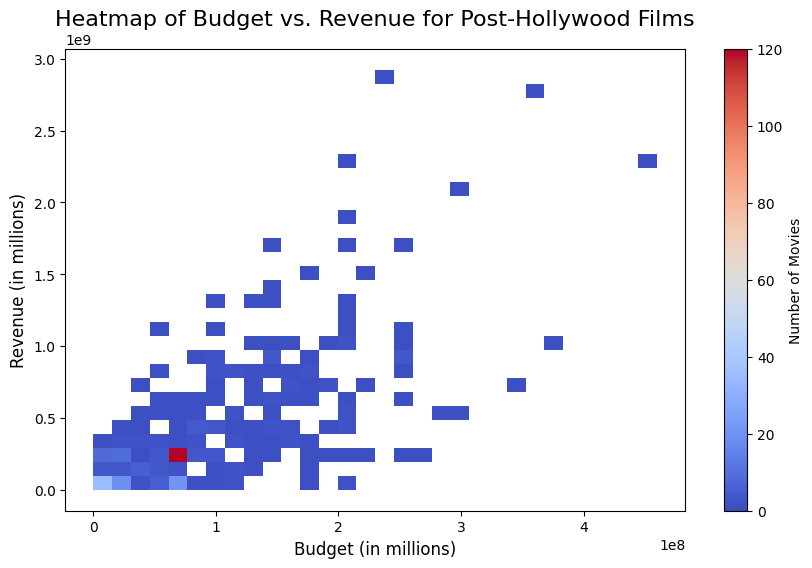

In [23]:
# Create a heatmap for Budget vs. Revenue
plt.figure(figsize=(10, 6))

heatmap = sns.histplot(data=films_df, x='Budget', y='Revenue', bins=30, cmap='coolwarm')

plt.title("Heatmap of Budget vs. Revenue for Post-Hollywood Films", fontsize=16)
plt.xlabel("Budget (in millions)", fontsize=12)
plt.ylabel("Revenue (in millions)", fontsize=12)

# Adding a color bar (legend) for reference
plt.colorbar(heatmap.collections[0], label='Number of Movies')

plt.show()

The heatmap effectively captures the variable relationship between film budgets and revenues, with a notable presence of high-budget, high-revenue outliers indicating significant financial success. The distribution suggests that while higher budgets often lead to greater revenues, the correlation is not deterministic, reflecting the film industry's inherent unpredictability. Therefore, we need further explore into the correlation.

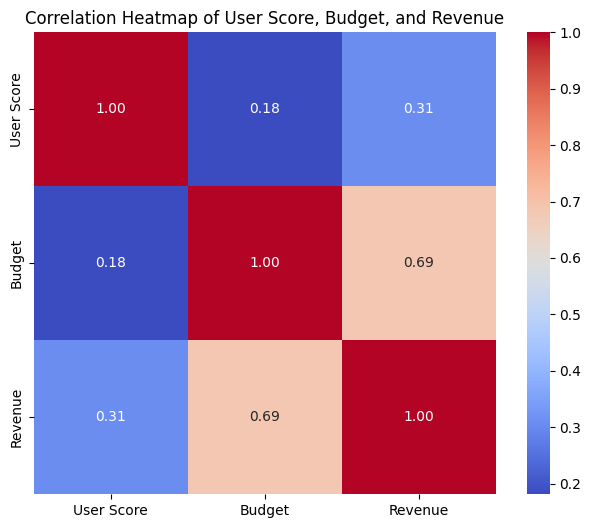

In [24]:
# Selecting relevant columns for correlation
correlation_data = films_df[['User Score', 'Budget', 'Revenue']]
# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

plt.figure(figsize=(8, 6))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)

plt.title("Correlation Heatmap of User Score, Budget, and Revenue")

plt.show()

The correlation heatmap provides a visual representation of the relationships between user score, budget, and revenue. It reveals a moderate positive correlation between budget and revenue (0.69), suggesting that higher budgets are associated with higher revenues. In contrast, the correlation between user score and both budget (0.18) and revenue (0.31) is relatively low, indicating that user satisfaction does not strongly predict either budget size or financial success.

> There is a notable correlation between budget and revenue, while user score has a limited correlation with these economic metrics.



## **3.6 Hypothesis Results Summary**

The analysis of the four hypotheses yielded significant findings regarding the dynamics of Post-Hollywood films. H1 demonstrated a robust positive correlation between higher user scores and increased revenue, underscoring the vital role of audience satisfaction in driving commercial success. H2 revealed that films with longer runtimes tended to receive higher user scores, suggesting audiences appreciate more in-depth storytelling. H3 confirmed that films directed by acclaimed directors generally achieve higher user scores, indicating the impact of directorial reputation on audience reception. Finally, H4 established a notable correlation between budget and revenue, with higher-budget films typically achieving more tremendous commercial success.

# **4. Additional Supporting Analysis**

In [25]:
# Export cleaned csv for further other software process
films_df.to_csv('films_cleaned.csv', index=False)

To enhance the validity of the hypothesis results, partial least squares structural equation modeling (PLS-SEM) was employed to investigate the intricate relationships among film attributes by using SmartPLS 4.0 [26], a specialized structural equation software known for its robust validation capabilities, even with small sample sizes [27]. PLS-SEM allows for a simultaneous examination of multiple variables, providing a comprehensive framework to understand how these attributes interact. This analysis not only confirms the direct effects outlined in the hypotheses but also reveals potential mediating factors, thereby offering a more nuanced perspective on the dynamics of commercial success in Post-Hollywood films [28].

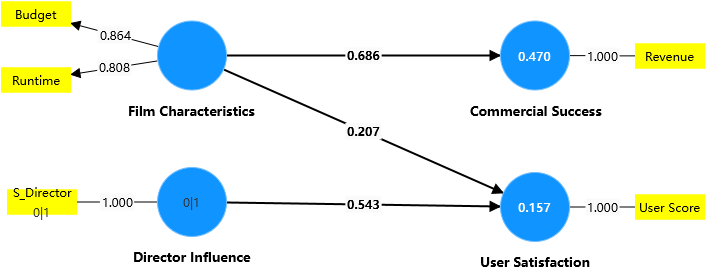

Figure 1: PLS-SEM results

According to Figure 1, the analysis reveals that **Film Characteristics**—comprising **Budget** and **Runtime**—have a strong positive impact on **Commercial Success**, with a path coefficient of 0.686, indicating that films with higher budgets and longer runtimes are more likely to achieve more significant revenue. Budget (loading = 0.864) and Runtime (loading = 0.808) load strongly onto the latent construct of Film Characteristics, highlighting their important contributions to this factor. **Director Influence**, measured solely by whether a famous director directs a film, has a moderately positive effect on **User Satisfaction** (path coefficient = 0.543). This suggests that films directed by notable directors are likely to receive higher user scores, pointing to a notable influence of recognized directors on audience reception. Additionally, **Film Characteristics** show a weak but positive relationship with **User Satisfaction** (path coefficient = 0.207), suggesting that while budget and runtime can contribute to user satisfaction, their influence is secondary compared to director influence. These findings support the previous hypothesis that higher-budget and longer-runtime films have a direct positive impact on revenue, while the presence of a notable director more strongly enhances user satisfaction.



# **5. Conclusion**
In conclusion, this research provides a comprehensive analysis of how key film attributes influence ratings and box office performance in the post-Hollywood era. H1 confirmed a strong positive correlation between user scores and revenue, emphasizing the centrality of audience satisfaction to commercial outcomes. H2 demonstrated that longer runtimes are generally associated with higher user scores, suggesting a preference among audiences for more elaborate narratives. H3 showed that films directed by highly regarded directors tend to receive higher user scores, highlighting the influence of directorial reputation on audience perceptions. Lastly, H4 established a positive link between budget and revenue, affirming that more significant financial investment often translates to higher commercial success. Together, these findings address our RQ by confirming that these transformative attributes do indeed positively correlate with both critical reception and commercial performance in the post-Hollywood era.

This study has several limitations that suggest opportunities for future research. The dataset, limited to 400 films, may restrict the generalizability of findings across the broader industry. Additionally, the range of attributes analyzed was constrained by data availability, leaving out potentially influential factors such as marketing reach or audience demographics. Future research could address these limitations by incorporating a more extensive and more diverse dataset, as well as expanding the scope of attributes studied. Employing advanced analytical techniques, such as machine learning and natural language processing, could further enhance understanding of the complex relationships between film characteristics, audience preferences, and market performance.

# **Acknowledgment**
Gratitude is extended to Colab for providing free cloud computing services for this project. Appreciation is also given to Mr. Zhe Ji from the BA English and Communication Studies program of XJTLU for valuable insights into the context of the Post-Hollywood Era.

**Copyright Notice**

© 2024 Mingyuan Li. All rights reserved.



# **Reference**

[1] S. Ryu, “How does film adaptation influence box office performance? An empirical analysis of science fiction films in Hollywood,” AAM, vol. 10, no. 3, pp. 125–143, Oct. 2020, doi: 10.1108/AAM-05-2019-0018.

[2] J. Ge, H. Chen, K. Qiu, and J. Sun, “Beyond the Box Office Performance: A Multi-Factor-Based Prediction Model for Sequel Movie,” in Proceedings of the 2023 5th International Conference on Big Data Engineering, Zhuhai China: ACM, Nov. 2023, pp. 42–46. doi: 10.1145/3640872.3640879.

[3] I. Pilászy and D. Tikk, “Recommending new movies: even a few ratings are more valuable than metadata,” in Proceedings of the third ACM conference on Recommender systems, New York New York USA: ACM, Oct. 2009, pp. 93–100. doi: 10.1145/1639714.1639731.

[4] J. Valentowitsch, “Hollywood caught in two worlds? The impact of the Bechdel test on the international box office performance of cinematic films,” Mark Lett, vol. 34, no. 2, pp. 293–308, Jun. 2023, doi: 10.1007/s11002-022-09652-5.

[5] P.-Y. Hsu, Y.-H. Shen, and X.-A. Xie, “Predicting Movies User Ratings with Imdb Attributes,” in Rough Sets and Knowledge Technology, vol. 8818, D. Miao, W. Pedrycz, D. Ślȩzak, G. Peters, Q. Hu, and R. Wang, Eds., in Lecture Notes in Computer Science, vol. 8818. , Cham: Springer International Publishing, 2014, pp. 444–453. doi: 10.1007/978-3-319-11740-9_41.

[6] F. Ahmed, M. T. Fattani, S. R. Ali, and R. N. Enam, “Strengthening the Bridge Between Academic and the Industry Through the Academia-Industry Collaboration Plan Design Model,” Front. Psychol., vol. 13, p. 875940, Jun. 2022, doi: 10.3389/fpsyg.2022.875940.

[7] J. M. Perkel, “Data visualization tools drive interactivity and reproducibility in online publishing,” Nature, vol. 554, no. 7690, pp. 133–134, Jan. 2018, doi: 10.1038/d41586-018-01322-9.

[8] J. F. Hair, J. J. Risher, M. Sarstedt, and C. M. Ringle, “When to use and how to report the results of PLS-SEM,” EBR, vol. 31, no. 1, pp. 2–24, Jan. 2019, doi: 10.1108/EBR-11-2018-0203.

[9] P. M. Bentler, “SEM with simplicity and accuracy,” J Consum Psychol, vol. 20, no. 2, pp. 215–220, Apr. 2010, doi: 10.1016/j.jcps.2010.03.002.

[10] M. Islam and S. Jin, “An Overview of Data Visualization,” in 2019 International Conference on Information Science and Communications Technologies (ICISCT), Tashkent, Uzbekistan: IEEE, Nov. 2019, pp. 1–7. doi: 10.1109/ICISCT47635.2019.9012031.

[11] M. E. Deagen et al., “FAIR and Interactive Data Graphics from a Scientific Knowledge Graph,” Sci Data, vol. 9, no. 1, p. 239, May 2022, doi: 10.1038/s41597-022-01352-z.

[12] O. Alabi and T. Bukola, “Introduction to Descriptive statistics,” in Recent Advances in Biostatistics, B. Santhosh Kumar, Ed., IntechOpen, 2023. doi: 10.5772/intechopen.1002475.

[13] “Google Colab” Accessed: Oct. 29, 2024. [Online]. Available: https://colab.research.google.com/

[14] “Popular Movies — The Movie Database (TMDB).” Accessed: Oct. 29, 2024. [Online]. Available: https://www.themoviedb.org/movie

[15] S. Reddy, S. Nalluri, S. Kunisetti, S. Ashok, and B. Venkatesh, “Content-Based Movie Recommendation System Using Genre Correlation,” in Smart Intelligent Computing and Applications, vol. 105, S. C. Satapathy, V. Bhateja, and S. Das, Eds., in Smart Innovation, Systems and Technologies, vol. 105. , Singapore: Springer Singapore, 2019, pp. 391–397. doi: 10.1007/978-981-13-1927-3_42.

[16] A.-L. Cohen, E. Shavalian, and M. Rube, “The Power of the Picture: How Narrative Film Captures Attention and Disrupts Goal Pursuit,” PLoS ONE, vol. 10, no. 12, p. e0144493, Dec. 2015, doi: 10.1371/journal.pone.0144493.

[17] Jaehoon Lee, Giseop Noh, and Chong-kwon Kim, “Analysis & visualization on movie’s popularity and reviews,” in 2014 International Conference on Big Data and Smart Computing (BIGCOMP), Bangkok, Thailand: IEEE, Jan. 2014, pp. 189–190. doi: 10.1109/BIGCOMP.2014.6741434.

[18] L. Kharb, D. Chahal, and Vagisha, “Forecasting Movie Rating Through Data Analytics,” in Data Science and Analytics, vol. 1230, U. Batra, N. R. Roy, and B. Panda, Eds., in Communications in Computer and Information Science, vol. 1230. , Singapore: Springer Singapore, 2020, pp. 249–257. doi: 10.1007/978-981-15-5830-6_21.

[19] W. Buckland, “What Does the Statistical Style Analysis of Film Involve? A Review of Moving into Pictures. More on Film History, Style, and Analysis,” Literary and Linguistic Computing, vol. 23, no. 2, pp. 219–230, Oct. 2007, doi: 10.1093/llc/fqm046.

[20] V. Nikolic, Independent Filmmaking and Digital Convergence, 0 ed. Routledge, 2016. doi: 10.4324/9781315675862.

[21] K. Marpe, “The Digital Art House: Independent Film Distribution in the Online Era,” UCLA, 2022. Accessed: Oct. 29, 2024. [Online]. Available: https://escholarship.org/uc/item/1bt8n90m

[22] R. Kolker, Ed., “Evolution of Modern-Day Independent Filmmaking,” in The Oxford Handbook of Film and Media Studies, Oxford University Press, 2008, p. 0. doi: 10.1093/oxfordhb/9780195175967.005.0001.

[23] E. L. Davids, “The Evolution of Film Genres: A Comparative Analysis of Hollywood and Bollywood,” AS, vol. 2, no. 4, pp. 15–34, Aug. 2023, doi: 10.56397/AS.2023.08.04.

[24] J. T. Leek and R. D. Peng, “What is the question?,” Science, vol. 347, no. 6228, pp. 1314–1315, Mar. 2015, doi: 10.1126/science.aaa6146.

[25] W. D. Walls, “Modelling heavy tails and skewness in film returns,” Applied Financial Economics, vol. 15, no. 17, pp. 1181–1188, Nov. 2005, doi: 10.1080/0960310050391040.

[26] “SmartPLS.” Accessed: Nov. 01, 2024. [Online]. Available: https://www.smartpls.com/

[27] A. J. Kim, J. Yang, Y. Jang, and J. S. Baek, “Acceptance of an Informational Antituberculosis Chatbot Among Korean Adults: Mixed Methods Research,” JMIR Mhealth Uhealth, vol. 9, no. 11, p. e26424, Nov. 2021, doi: 10.2196/26424.

[28] D. R. Bacon, P. L. Sauer, and M. Young, “Composite Reliability in Structural Equations Modeling,” Educational and Psychological Measurement, vol. 55, no. 3, pp. 394–406, Jun. 1995, doi: 10.1177/0013164495055003003.



